Hunter Bennett  
Glass Lab  
Created 180205 | Last updated 180205  
____________  
here we are seeking to understand if there are noticeable molecular phenotype within 4 weeks on the NASH diet.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
#  %load_ext rpy2.ipython

sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

Make output directory

In [3]:
# define output directory
outdir = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

In [4]:
# set working directory
workingDirectory = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [5]:
# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/LXR/data/mm10_refseq_genename.txt', sep='\t', names=['refseq_id', 'gene'], index_col=0)

Set some user defined functions

In [6]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = hbUtils.df_col_subset(tpm, strain + '.*' + tissue)
    tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)
    tmp_df.columns = pd.Series(tmp_df.columns).replace(np.nan, 'NNaF')
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))


### Do Some RNA QC

In [103]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [115]:
# make summary table of qc stats
qc_stats = pd.DataFrame()

for sample in os.listdir('./tag_directories_rna/'):
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_rna/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_rna/'+sample+'/'):
        if file.endswith(".log"):
            f = open('./tag_directories_rna/'+sample+'/'+file)
            txt = f.read()
            star_log = list(filter(None, re.split('\s|\|',txt)))
            qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
            qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
            qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
            qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
            qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                    qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                    / qc_stats.loc[sample, 'totalReads']
            qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                            - qc_stats.loc[sample, 'totalReads']
    if not any(fname.endswith('.log') for fname in os.listdir('./tag_directories_rna/'+sample+'/')):
        print(sample + ' does not contain a mapping log file')
        qc_stats.loc[sample, 'totalReads'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedReads'] = np.nan
        qc_stats.loc[sample, 'multiMappedReads'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_short'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_other'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedFraction'] = np.nan
        qc_stats.loc[sample, 'mappedFraction'] = np.nan

qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_rna/mapping_stats.tsv', sep='\t')

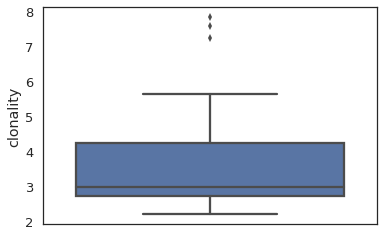

In [116]:
# clonality boxplot
fig = sns.boxplot(y=qc_stats['clonality']).get_figure()
fig.savefig('./qc_rna/clonality_boxplot_hb.pdf', bbox_inches='tight')

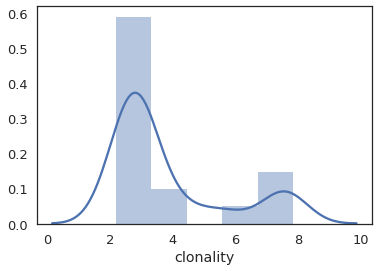

In [117]:
# clonality distplot
fig = sns.distplot(qc_stats['clonality']).get_figure()
fig.savefig('./qc_rna/clonality_distplot_hb.pdf', bbox_inches='tight')

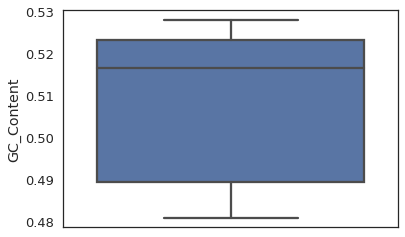

In [118]:
# GC_Content boxplot
fig = sns.boxplot(y=qc_stats['GC_Content']).get_figure()
fig.savefig('./qc_rna/GC_Content_boxplot_hb.pdf', bbox_inches='tight')

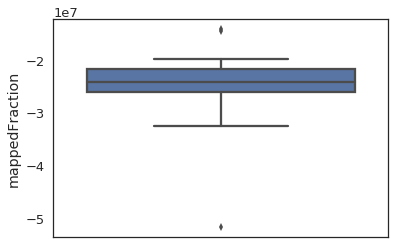

In [119]:
# mapped fraction boxplot
fig = sns.boxplot(y=qc_stats['mappedFraction']).get_figure()
fig.savefig('./qc_rna/mappedFraction_boxplot_hb.pdf', bbox_inches='tight')

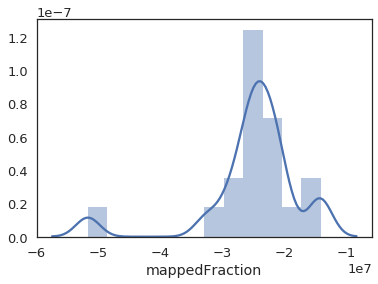

In [120]:
# mapped fraction distplot
fig = sns.distplot(qc_stats['mappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna/mappedFraction_distplot_hb.pdf', bbox_inches='tight')

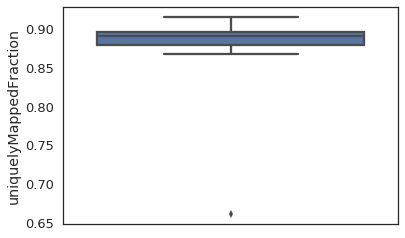

In [121]:
# uniquely Mapped Fraction boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedFraction_boxplot_hb.pdf', bbox_inches='tight')

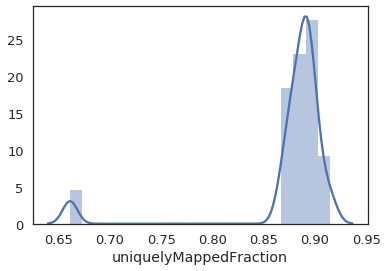

In [122]:
# uniquely Mapped Fraction distplot
fig = sns.distplot(qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedFraction_distplot_hb.pdf', bbox_inches='tight')

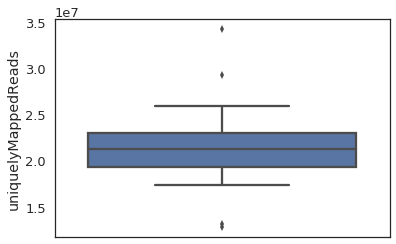

In [123]:
# uniquely Mapped Reads boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedReads'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

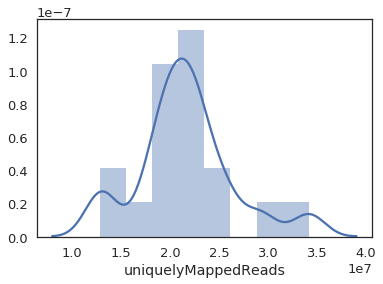

In [124]:
# uniquely Mapped Reads distplot
fig = sns.distplot(qc_stats['uniquelyMappedReads'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

In [125]:
qc_stats

,uniquePositions,fragmentLengthEstimate,tagsPerBP,clonality,GC_Content,totalReads,uniquelyMappedReads,multiMappedReads,frac_unmappedReads_mismatch,frac_unmappedReads_short,frac_unmappedReads_other,uniquelyMappedFraction,mappedFraction
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288A,2463443.0,75.0,0.006872,7.592,0.481,21018277.0,18701930.0,1604619.0,0.0,0.0249,0.0035,0.889794,-2.101828e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288B,2402718.0,75.0,0.006392,7.239,0.489,19768880.0,17393461.0,1448621.0,0.0,0.0386,0.0034,0.879840,-1.976888e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN289A,2730750.0,75.0,0.007873,7.846,0.489,24575571.0,21424651.0,1654704.0,0.0,0.0532,0.0030,0.871786,-2.457557e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574A,7368359.0,75.0,0.008113,2.997,0.491,25016919.0,22083702.0,2284661.0,0.0,0.0135,0.0021,0.882751,-2.501692e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574B,8115862.0,75.0,0.010757,3.607,0.505,32579250.0,29277630.0,2752898.0,0.0,0.0093,0.0015,0.898659,-3.257925e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN200cM,6840560.0,75.0,0.007745,3.081,0.518,23605784.0,21075043.0,1945885.0,0.0,0.0143,0.0044,0.892791,-2.360578e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN201cM,6058440.0,75.0,0.012568,5.644,0.524,51733819.0,34195455.0,2857457.0,0.0,0.2759,0.0035,0.660988,-5.173382e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN203dM,7077331.0,75.0,0.007090,2.726,0.524,21533789.0,19290102.0,1904975.0,0.0,0.0047,0.0041,0.895806,-2.153379e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN144B,9060304.0,75.0,0.009520,2.859,0.515,29154581.0,25905384.0,2786192.0,0.0,0.0034,0.0044,0.888553,-2.915458e+07
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146C,5607450.0,75.0,0.009164,4.446,0.524,28007294.0,24931841.0,2631333.0,0.0,0.0050,0.0039,0.890191,-2.800729e+07


### Generate RNA Seq Files

In [126]:
%%bash
# if directories don't exist, create them
if [ ! -d ./expression/ ]; then mkdir ./expression; fi

analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288A
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN289A
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574A
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN200cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN201cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN203dM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN144B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146C
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146D
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN152B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4wk_LN352A
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4w

In [127]:
%%bash
source activate rrrr
getDiffExpression.pl ./expression/rna_exp_raw.tsv G03_10wk G03_10wk G03_10wk G05_1wk G05_1wk G02_20wk G02_20wk G02_20wk G01_30wk G01_30wk G01_30wk G01_30wk G04_4wk G04_4wk G07_0wk_control G07_0wk_control G06_20wk_control G06_20wk_control -AvsA > ./expression/diff_output.txt




	Differential Expression Program: DESeq2
	Autodetecting input file format...
	Using DESeq2 to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file

	Performing variance stabalization (rlog)...

	Output Stats G03_10wk vs. G05_1wk:
		Total Genes: 24537
		Total Up-regulated in G05_1wk vs. G03_10wk: 264 (1.076%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in G05_1wk vs. G03_10wk: 460 (1.875%) [log2fold<-1, FDR<0.05]
	Output Stats G03_10wk vs. G02_20wk:
		Total Genes: 24537
		Total Up-regulated in G02_20wk vs. G03_10wk: 898 (3.660%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in G02_20wk vs. G03_10wk: 1195 (4.870%) [log2fold<-1, FDR<0.05]
	Output Stats G03_10wk vs. G01_30wk:
		Total Genes: 24537
		Total Up-regulated in G01_30wk vs. G03_10wk: 1029 (4.194%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in G01_30wk vs. G03_10wk: 1345 (5.482%) [log2fold<-1, FDR<0.05]
	Output Stats G03_10wk vs. G04_4wk:
		Total Genes: 24537
		Total Up-regulated in G04_4wk vs. G03

In [128]:
%%bash
makeMultiWigHub.pl hrb_tim4pos_timecourse_hub mm10 -d ./tag_directories_rna/*


	Once finished, you will want to upload the following hub URL:
		http://homer.ucsd.edu/hubs//hrb_tim4pos_timecourse_hub/hub.txt

	If loading to the Wash U Epigenome Browser, use:
		http://homer.ucsd.edu/hubs//hrb_tim4pos_timecourse_hub/washU.hub.txt

!!! Warning - /homer_data/www/html/hubs//hrb_tim4pos_timecourse_hub exists !!!
!!! Rerun command with -force to overwrite !!!


In [377]:
# import differential gene expression
diff_gene = pd.read_csv('./expression/diff_output.txt', sep='\t', index_col=0)
print(diff_gene.shape)

# create gene name index
diff_gene = diff_gene.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
diff_gene = diff_gene.reset_index().set_index('gene').drop(columns='index')

# filter entries without a gene
diff_gene = diff_gene.loc[diff_gene.index.notna(), :]
print(diff_gene.shape)

(24537, 88)
(24493, 88)


###  First take a look at pairwise scatterplots of the individuals

we will use a tpm matrix for most of our plotting

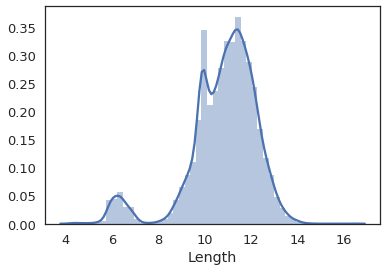

In [136]:
rpkm = pd.read_csv(outdir + './expression/rna_exp_rpkm.tsv', sep='\t')
# set rpkm index
rpkm.set_index(rpkm.columns.values[0], inplace=True)
rpkm.index.rename('refseqID', inplace=True)
a
# clean up column names
# rename rpkm columns
rpkm = rpkm.rename(columns=dict(zip(rpkm.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))
sns.distplot(np.log2(rpkm.Length + 1))

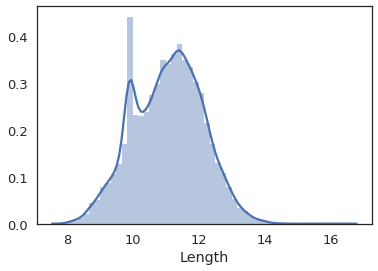

In [138]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 250, :]
sns.distplot(np.log2(rpkm.Length + 1))

### Create a sample datasheet

In [2]:
samples = pd.Series(rpkm.iloc[:, 7:].columns.values)
cage = samples.str.split('_').str[-1]
group = ['_'.join(i) for i in samples.str.split('_').str[:-1]]

samplesDF = pd.DataFrame([pd.Series(samples),
              pd.Series(cage),
              pd.Series(group)],
              index=['sample', 'cage', 'group']).T

NameError: name 'pd' is not defined

In [1]:
cols

NameError: name 'cols' is not defined

### Convert to tpm

In [139]:
tpm_mat = (rpkm.iloc[:, 7:] / rpkm.iloc[:, 7:].sum()) * 1000000

In [303]:
# create avg tpm matrix for filtering
tpm_avg = pd.DataFrame([
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_1wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_10wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_20wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_30wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_4wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_0wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_20wk'))].mean(1)],
    index=['AMLNDiet_1wk', 'AMLNDiet_10wk', 'AMLNDiet_20wk',
           'AMLNDiet_30wk', 'AMLNDiet_4wk', 'Control_0wk',
           'Control_20wk']).T

# filter genes not expressed at least 1 tpm across more than half of samples
tpm_filt = tpm_mat.loc[(tpm_avg > 4).any(1), :]

# change index to gene names
tpm_filt = tpm_filt.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
tpm_filt = tpm_filt.reset_index().set_index('gene').drop(columns='index')

# sort columns (manually for now)
cols = tpm_filt.columns.values
tpm_mat_filt = tpm_filt.reindex([cols[15],
                      cols[14], cols[3], cols[4],
                      cols[12], cols[13], cols[0],
                      cols[1], cols[2], cols[5],
                      cols[6], cols[7], cols[8],
                      cols[9], cols[10], cols[11]],
                      axis=1)

tpm_mat_zscore = tpm_mat_filt.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# Descriptive analysis of our data

In [305]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_filt)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.group])).reset_index()
tpm_pca_df['cage'] = samplesDF['cage']

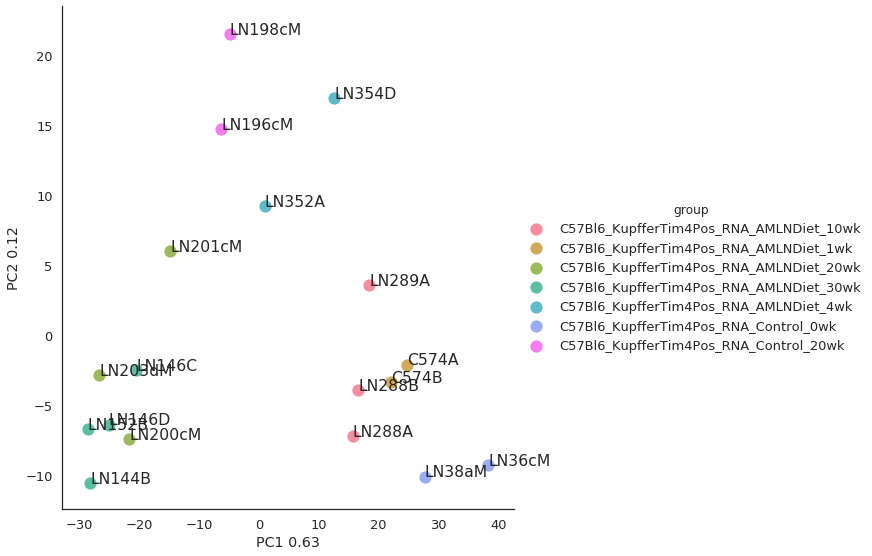

In [306]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=8, scatter_kws={'s': 150},
                legend=True)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.cage, plt.gca())

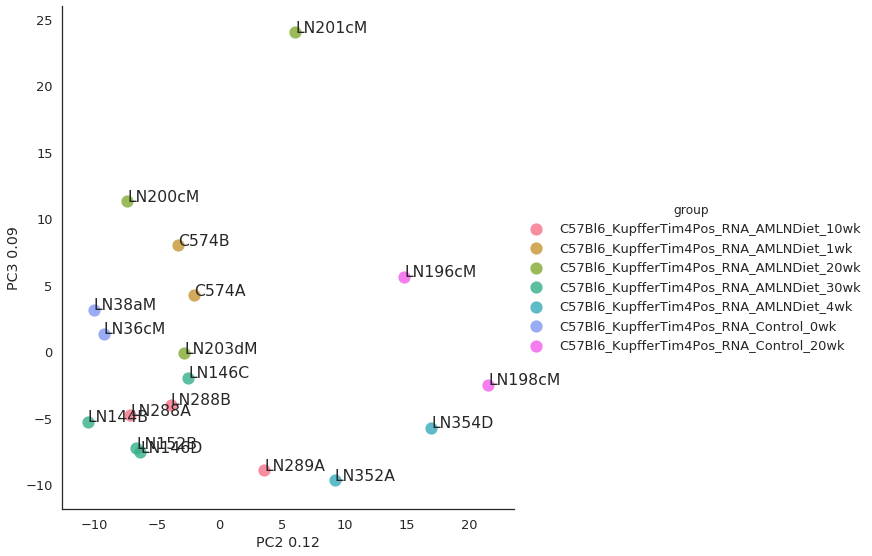

In [307]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=8, scatter_kws={'s': 150})
ax.set(xlabel=('PC2 %.2f' % exp_var[1]), ylabel=('PC3 %.2f' % exp_var[2]))
label_point(tpm_pca_df.PC2, tpm_pca_df.PC3, tpm_pca_df.cage, plt.gca())

In [152]:
# look at the genes with the highest loading in PC1
transcript_pc = pd.DataFrame(pca.components_.T, rpkm.index, columns=['PC1','PC2','PC3'])
transcript_pc.sort_values(by = 'PC1', ascending=False).head(10)

,PC1,PC2,PC3
refseqID,,,
NM_021278,0.391482,-0.370408,-0.261733
NM_016751,0.322845,0.078896,-0.043097
NM_007995,0.183857,0.057906,-0.015881
NM_007572,0.183544,0.019590,-0.173098
NM_009690,0.177111,0.043731,0.178654
NM_009735,0.160430,-0.210558,-0.002248
NM_001081957,0.156375,-0.067736,0.022211
NM_007574,0.151285,0.003291,-0.043879
NM_177789,0.136360,-0.053453,-0.027336


### Heatmap

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


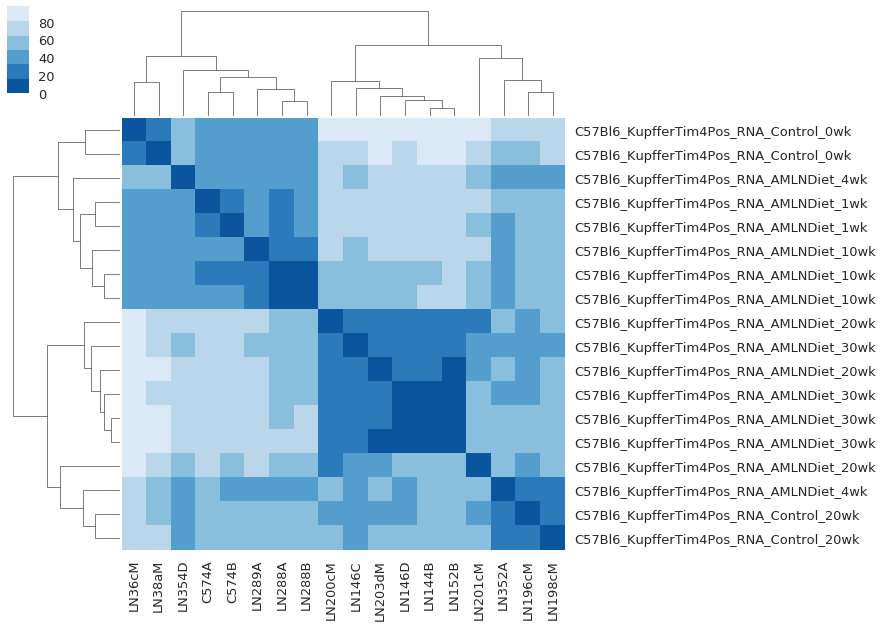

In [153]:
from scipy.spatial import distance
tpm_dist = pd.DataFrame(distance.squareform(distance.pdist(tpm_std.T, 'euclidean')),
                        columns = list(samplesDF.cage),
                        index = list(samplesDF.group))
# plot values using sns clustermap - ignore error as we know we are putting in a distance mat
g = sns.clustermap(tpm_dist, cmap=sns.color_palette("Blues_r"))

### Cluster most variable genes - top 10k, 1k

In [312]:
var_rank = tpm_filt.var(1).rank(ascending=False)

Top 10000

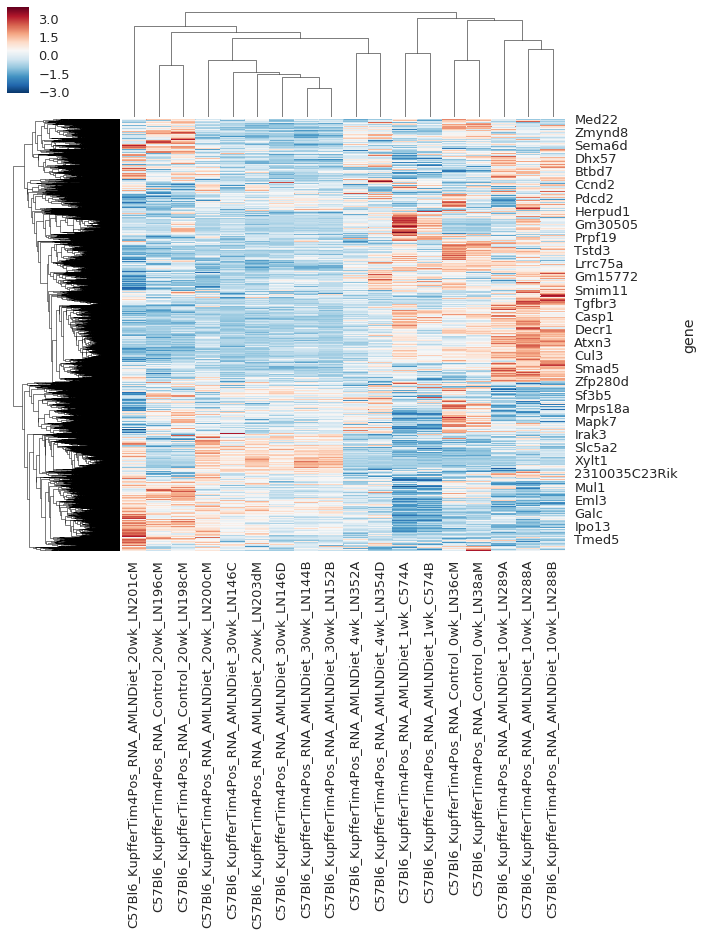

In [320]:
sns.clustermap(
    tpm_filt.loc[var_rank <= 10000, :],
    z_score=0,
    cmap='RdBu_r')
    # col_cluster=False)

Top 1000

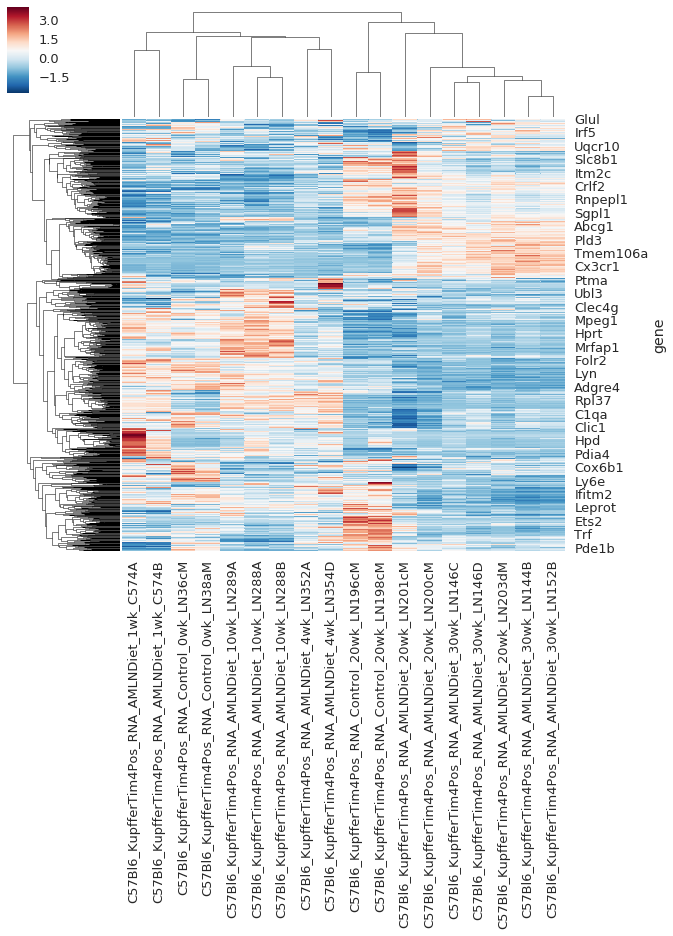

In [322]:
sns.clustermap(
    tpm_filt.loc[var_rank <= 1000, :],
    z_score=0,
    cmap='RdBu_r')
    # col_cluster=False)

# Import DESeq2 results

In [154]:
def pull_comparision(diff_gene, comp):
    return diff_gene.loc[:, [comp + ' Log2 Fold Change',
                            comp + ' p-value',
                            comp + ' adj. p-value']]

In [378]:
# extract groups
comp_dict = {}
pattern='(\w* vs. \w*).*'
for col in diff_gene.columns.values:
    m = re.search(string=col, pattern=pattern)
    if m:
        df = pull_comparision(diff_gene, m.group(1))
        df.columns = ['log2fc', 'pval', 'adj_pval']
        comp_dict[re.sub('G0[0-9]_', '', m.group(1))] = df        

### Set p value and fc cutoffs

In [379]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

### What genes are turned on at 1 week and stay up throughout the rest of the diet?
_____
Easiest way to do this: pick out significantly upregulated genes at 1wk then ones that have low fold change (maybe w/in 1.3?) between 1 week and all other samples

In [420]:
tpm_mat_filt.T['Scd1']

C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN38aM       141.858360
C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN36cM       127.332404
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574A       451.471930
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574B       702.908298
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4wk_LN352A      308.292331
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4wk_LN354D      402.683833
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288A     515.137854
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288B     356.923972
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN289A     281.476008
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN200cM    392.428601
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN201cM    444.454569
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN203dM    304.870396
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN144B     435.438420
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146C     390.063289
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146D     357.471647
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN152B     446.371052
Name: Sc

In [433]:
onewk_up = ( comp_dict['1wk vs. 0wk_control'].adj_pval <= pval ) & \
( comp_dict['1wk vs. 0wk_control'].log2fc <= -fc )

In [429]:
comp_dict['1wk vs. 0wk_control'].loc['Scd1', :]

log2fc     -2.302817e+00
pval        6.949444e-22
adj_pval    8.139122e-20
Name: Scd1, dtype: float64

In [445]:
onewk_up = ( comp_dict['1wk vs. 0wk_control'].adj_pval <= pval ) & \
( comp_dict['1wk vs. 0wk_control'].log2fc <= -fc ) & \
( np.abs(comp_dict['1wk vs. 4wk'].log2fc) <= np.log2(1.7) ) & \
( np.abs(comp_dict['10wk vs. 1wk'].log2fc) <= np.log2(1.7) ) & \
( np.abs(comp_dict['1wk vs. 20wk'].log2fc) <= np.log2(1.7) ) & \
( np.abs(comp_dict['1wk vs. 30wk'].log2fc) <= np.log2(1.7) )


In [382]:
fourwk_up = ( comp_dict['1wk vs. 4wk'].adj_pval <= pval ) & \
( comp_dict['1wk vs. 4wk'].log2fc >= fc ) & \
( np.abs(comp_dict['10wk vs. 4wk'].log2fc) <= np.log2(1.25) ) & \
( np.abs(comp_dict['20wk vs. 4wk'].log2fc) <= np.log2(1.25) ) & \
( np.abs(comp_dict['30wk vs. 4wk'].log2fc) <= np.log2(1.25) )

In [383]:
tenwk_up = ( comp_dict['10wk vs. 4wk'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 4wk'].log2fc <= -fc ) & \
( np.abs(comp_dict['10wk vs. 20wk'].log2fc) <= np.log2(1.25) ) & \
( np.abs(comp_dict['10wk vs. 30wk'].log2fc) <= np.log2(1.25) )

In [453]:
twentywk_up = ( comp_dict['10wk vs. 20wk'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 20wk'].log2fc >= fc ) & \
( np.abs(comp_dict['20wk vs. 30wk'].log2fc) <= np.log2(1.3) )

In [454]:
twentywk_dn = ( comp_dict['10wk vs. 20wk'].adj_pval <= pval ) & \
( comp_dict['10wk vs. 20wk'].log2fc <= -fc ) & \
( np.abs(comp_dict['20wk vs. 30wk'].log2fc) <= np.log2(1.3) )

In [455]:
with open('./expression/tmp_up_list.txt', 'w') as f:
    for val in twentywk_up[twentywk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression/tmp_dn_list.txt', 'w') as f:
    for val in twentywk_dn[twentywk_dn].index.values:
        f.write(val+'\n')
f.close()

In [456]:
twentywk = np.concatenate((twentywk_up[twentywk_up].index.values,
                          twentywk_dn[twentywk_dn].index.values))

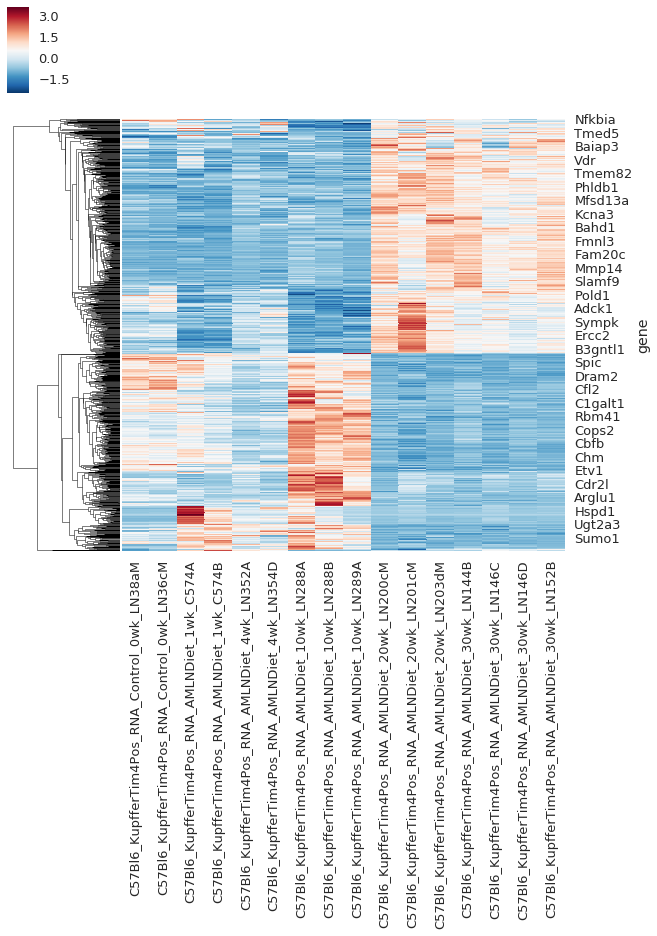

In [457]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentywk)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

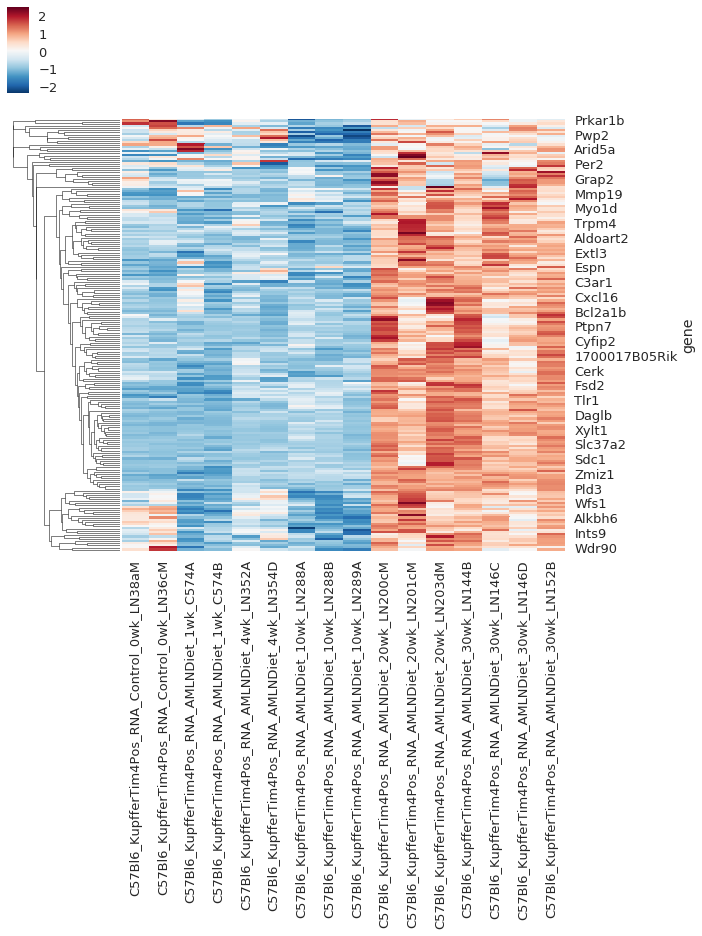

In [393]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentywk_up[twentywk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

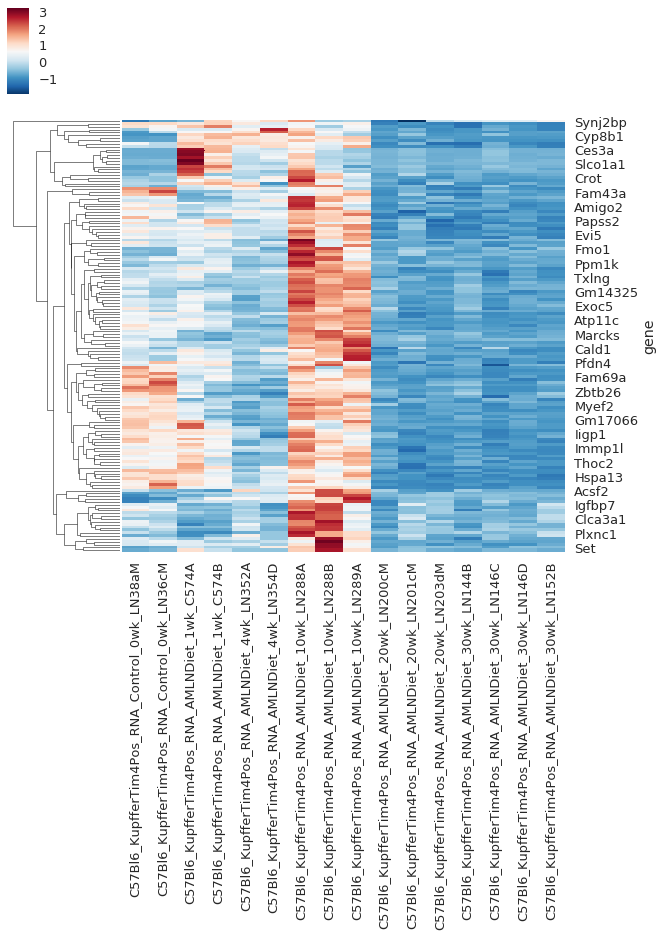

In [389]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentywk_dn[twentywk_dn].index.values)].dropna(),
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

### 4 week diet effect

In [45]:
c57bl6_amln_4wk_deseq_p01_fc2_up = deseq_4wk.loc[
    ((deseq_4wk['4wk vs. 0wk_control adj. p-value'] <= pval) &\
    (deseq_4wk['4wk vs. 0wk_control Log2 Fold Change'] > fc)), :].index.values

c57bl6_amln_4wk_deseq_p01_fc2_dn = deseq_4wk.loc[
    ((deseq_4wk['4wk vs. 0wk_control adj. p-value'] <= pval) &\
    (deseq_4wk['4wk vs. 0wk_control Log2 Fold Change'] < -fc)), :].index.values

# write output for uploading to metascape
f = open('./gene_lists/c57bl6_amln_4wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open('./gene_lists/c57bl6_amln_4wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 1 week diet effect

In [46]:
#### Write gene list for analysis with metascape
c57bl6_amln_1wk_deseq_p01_fc2_up = deseq_1wk.loc[
    ((deseq_1wk['1wk vs. 0wk_control adj. p-value'] <= pval) &\
    (deseq_1wk['1wk vs. 0wk_control Log2 Fold Change'] > fc)), :].index.values

c57bl6_amln_1wk_deseq_p01_fc2_dn = deseq_1wk.loc[
    ((deseq_1wk['1wk vs. 0wk_control adj. p-value'] <= pval) &\
    (deseq_1wk['1wk vs. 0wk_control Log2 Fold Change'] < -fc)), :].index.values

# write output for uploading to metascape
f = open('./gene_lists/c57bl6_amln_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_1wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open('./gene_lists/c57bl6_amln_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_1wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 4 vs 1 week diet effect

In [53]:
#### Write gene list for analysis with metascape
c57bl6_amln_4wk_1wk_deseq_p01_fc2_up = deseq_4wk_1wk.loc[
    ((deseq_4wk_1wk['1wk vs. 4wk adj. p-value'] <= pval) &\
    (deseq_4wk_1wk['1wk vs. 4wk Log2 Fold Change'] < -fc)), :].index.values

c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn = deseq_4wk_1wk.loc[
    ((deseq_4wk_1wk['1wk vs. 4wk adj. p-value'] <= pval) &\
    (deseq_4wk_1wk['1wk vs. 4wk Log2 Fold Change'] > fc)), :].index.values

# write output for uploading to metascape
f = open('./gene_lists/c57bl6_amln_4wk_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_up.astype(str).tolist())
f.write(gene_list)
f.close()

f = open('./gene_lists/c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

# Comparing Differential Gene Expression

In [54]:
tpm_mat = (rpkm.iloc[:, 7:] / rpkm.iloc[:, 7:].sum()) * 1000000

In [82]:
# create avg tpm matrix for filtering
tpm_avg = pd.DataFrame([
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_1wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_10wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_20wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_30wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_4wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_0wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_20wk'))].mean(1)],
    index=['AMLNDiet_1wk', 'AMLNDiet_10wk', 'AMLNDiet_20wk',
           'AMLNDiet_30wk', 'AMLNDiet_4wk', 'Control_0wk',
           'Control_20wk']).T

# filter genes not expressed at least 1 tpm across more than half of samples
tpm_mat_filt = tpm_mat.loc[(tpm_avg > 4).any(1), :]

# change index to gene names
tpm_mat_filt = tpm_mat_filt.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
tpm_mat_filt = tpm_mat_filt.reset_index().set_index('gene').drop(columns='index')

# sort columns (manually for now)
cols = tpm_mat_filt.columns.values
tpm_mat_filt = tpm_mat_filt.reindex([cols[16], cols[15],
                      cols[14], cols[3], cols[4],
                      cols[12], cols[13], cols[0],
                      cols[1], cols[2], cols[5],
                      cols[6], cols[7], cols[8],
                      cols[9], cols[10], cols[11]],
                      axis=1)

tpm_mat_zscore = tpm_mat_filt.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

Lets just look at the ge patterns for 1 week differential genes

1104


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


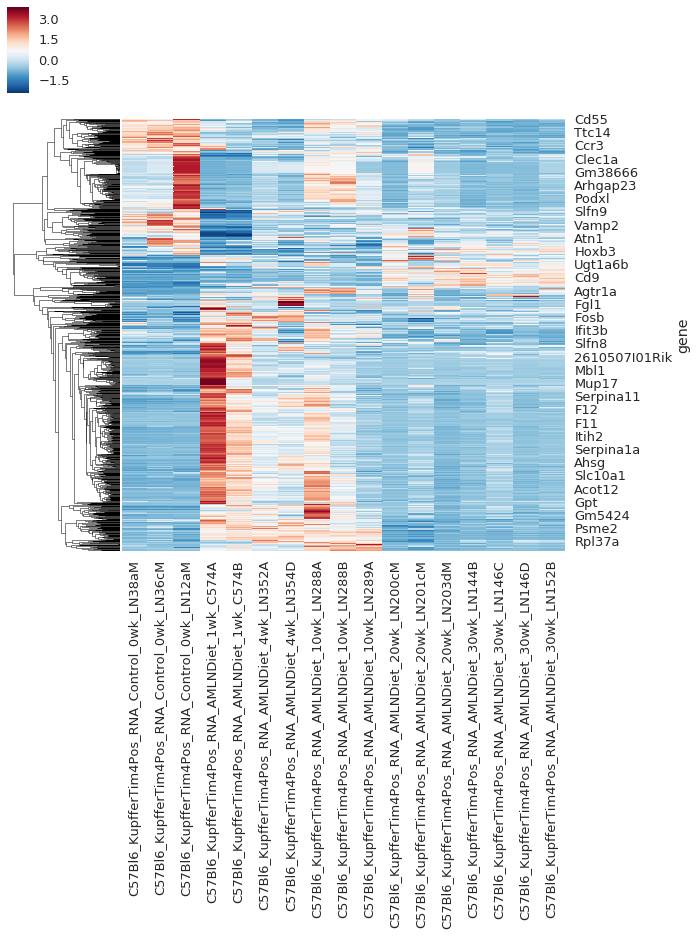

In [83]:
x = list(c57bl6_amln_1wk_deseq_p01_fc2_dn)
x.extend(list(c57bl6_amln_1wk_deseq_p01_fc2_up))
x.extend(list(c57bl6_amln_4wk_deseq_p01_fc2_up))
x.extend(list(c57bl6_amln_4wk_deseq_p01_fc2_dn))
x = set(x)
print(len(x))
sns.clustermap(tpm_mat_filt.loc[x, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

Lets call DE genes on 30 week and 20 week then take ones that are significant at any time point then look at the FC pattern.

### What about genes that are downregulated and stay low

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


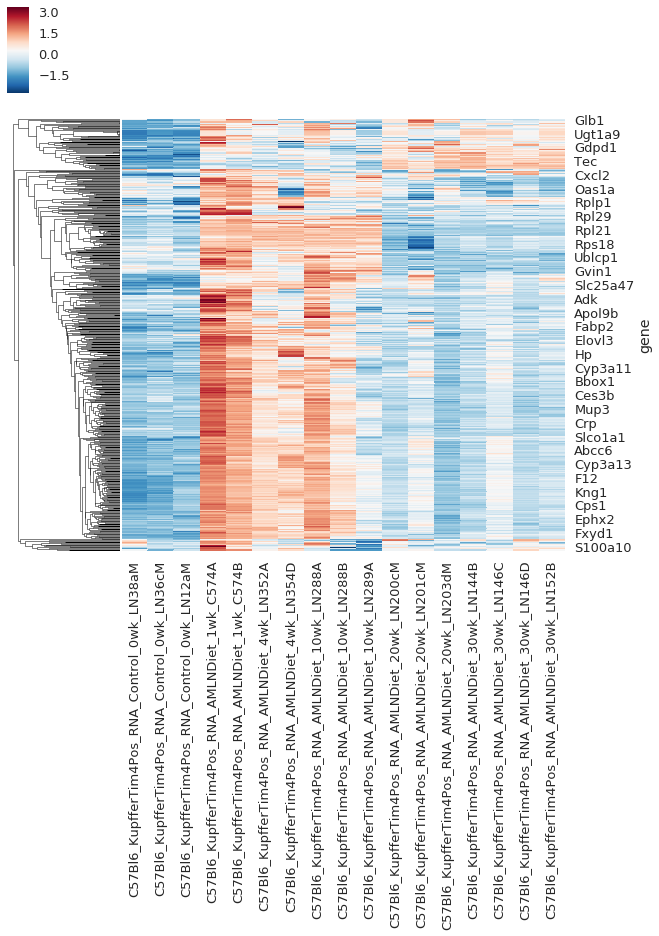

In [84]:
sns.clustermap(np.log2(tpm_mat_filt.loc[c57bl6_amln_1wk_deseq_p01_fc2_dn, :].dropna() + 1), z_score=0, cmap='RdBu_r', col_cluster=False)

How many genes go up then down week 1 to 4 vs down to up week 1 to 4?

In [85]:
deseq_down_up = list(set(c57bl6_amln_1wk_deseq_p01_fc2_dn).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
deseq_down_up_refseq = mm10_refseq.loc[[(gene in deseq_down_up) for gene in mm10_refseq.gene], :].index.tolist()

deseq_up_down = list(set(c57bl6_amln_1wk_deseq_p01_fc2_up).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
deseq_up_down_refseq = mm10_refseq.loc[[(gene in deseq_up_down) for gene in mm10_refseq.gene], :].index.tolist()

In [86]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_dn))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
print(len(deseq_down_up))

706
213
155


In [87]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_up))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
print(len(deseq_up_down))

271
133
44


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


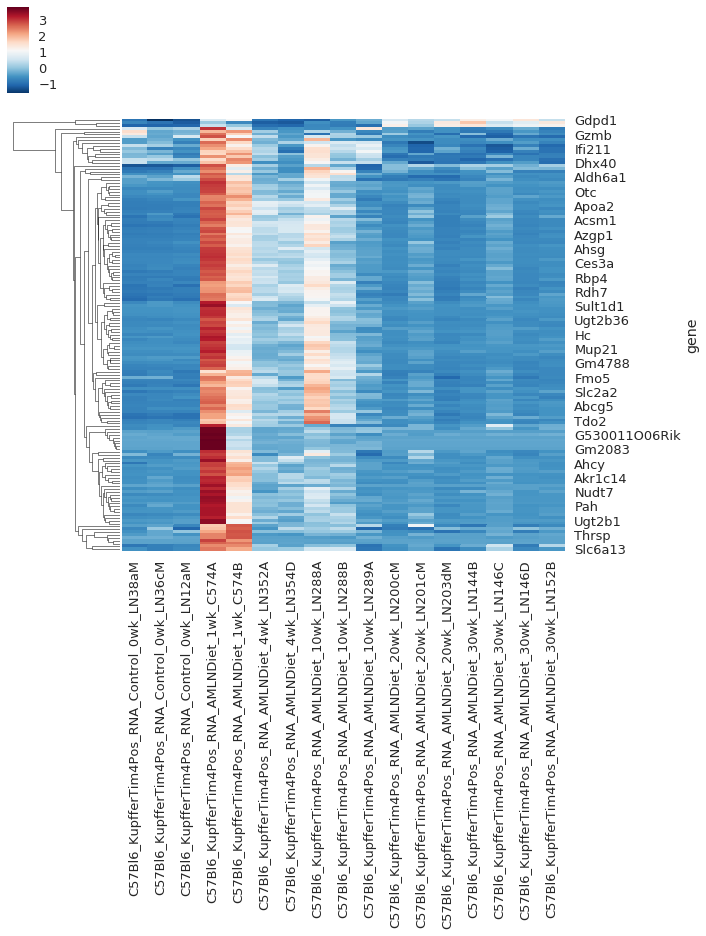

In [88]:
sns.clustermap(tpm_mat_filt.loc[deseq_down_up, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

* Slc27a3 is a long chain fatty acid metabolic compount (acyl-CoA ligase) in mitochondrial beta oxidation gene, FA + CoA +ATP --> Acyl-CoA + AMP. Maybe 1 week KCs are turning off beta oxidation?
* Cpt1b rate controlling enzyme of long chain fatty acid beta oxidation, transports FA into mitochondria from cytoplasm
* Spred3 and Tnk1 both negatively regulate the MAPK pathway
* Setd1b is part of HMT complex that trimethylates H3 at Lys4
* Adgrg6 activated by type IV collagen
* Atn is transcriptional corepressor. Phf21b is a TF. Maml3 is a NOTCH coactivator
* FBRS induces fibroblasts proliferation
* Col11a2 and Col7a1 collagen compounds (obviously), mmp14 breaks down collagen
* Marco is classic KC gene - scavenger receptor for gram negative and gram positive bacteria
* Kcp inhibits TGFB signaling

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


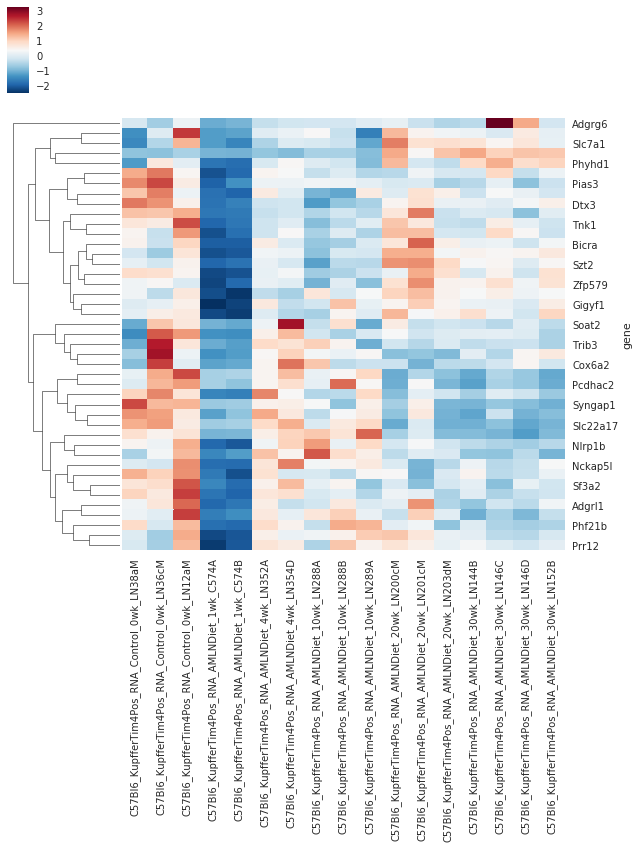

In [89]:
sns.set(font_scale=1)
sns.clustermap(tpm_mat_filt.loc[deseq_up_down, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

In [90]:
', '.join(deseq_up_down)

'Trib3, Slc7a5, Col11a2, Leng8, Spred3, Nlrp1b, Setd1b, Gigyf1, Tnk1, Adgrg6, Nudt16, Bicra, Slc27a3, Prr12, Pde1b, Marco, Mir7654, Sf3a2, AA465934, Mmp14, Plscr3, Adgrl1, Pias3, Nckap5l, Phf21b, Kcp, Syngap1, Phyhd1, Slc7a1, Atn1, Soat2, Asns, Szt2, Wdfy1, Zfp579, Slfn9, Cox6a2, Dtx3, Fbrs, Slc22a17, Pcdhac2, Mbd6, Dock6, Wiz'

* Mapkapk3 activated by map kinase. Phosphorylates inflammatory genes
* Ifi205 activates NLRP3 inflammasome in resposne to
* Hsd3b5 is a steroid biosynthesis pathway enzyme, Cyp4a12 is a steroid oxidizer
* Cyp2c mice involved  in conjugation and creation of bile acids.
* Rdh7 is involved in retinol metabolism

### How do KC Specific Genes change

In [396]:
import scipy.cluster

278
275


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See 

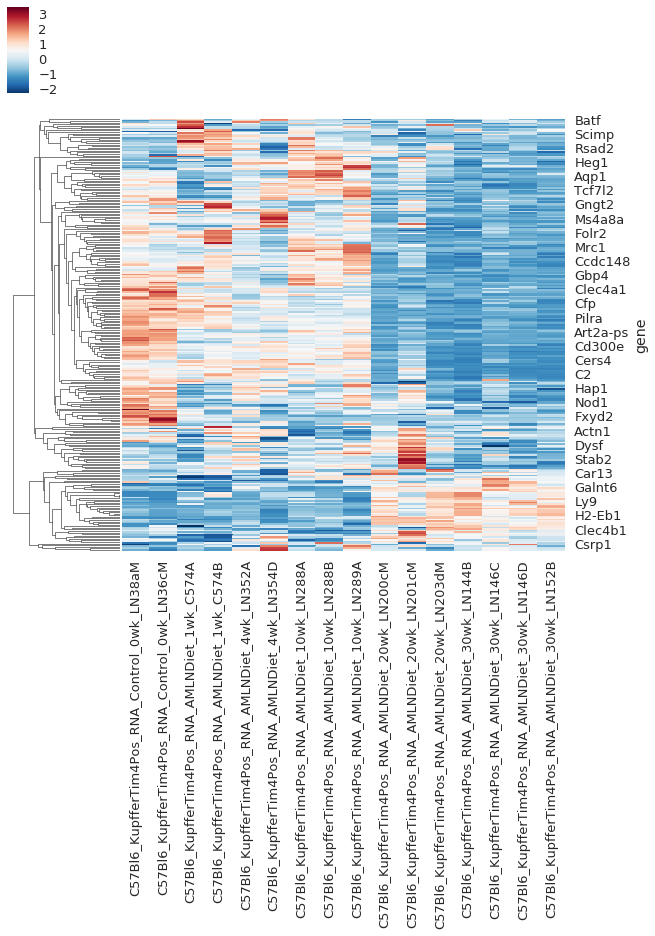

In [397]:
with open('/home/h1bennet/liverStrains/data/mouse/KC_specific_C57_AJ_BALB.txt', 'r') as f:
    kc_genes = [i.strip('"') for i in f.read().split()]

print(len(kc_genes))
print(tpm_mat_zscore.loc[kc_genes, :].dropna().shape[0])
rowclust = scipy.cluster.hierarchy.linkage(tpm_mat_zscore.loc[kc_genes, :].dropna(),
                                           method='average')

kc = sns.clustermap(tpm_mat_filt.loc[kc_genes, :].dropna(),
                    z_score=0, cmap='RdBu_r', col_cluster=False,
                    row_linkage=rowclust)

kc.savefig('./figures/KC_specific_C57_AJ_Balb_heatmap.png', bbox_inches='tight')

In [405]:
row_two_clust = (scipy.cluster.hierarchy.cut_tree(rowclust, n_clusters=2) == 1)
row_two_clust = [i[0] for i in row_two_clust]

In [408]:
len(row_two_clust)

275

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


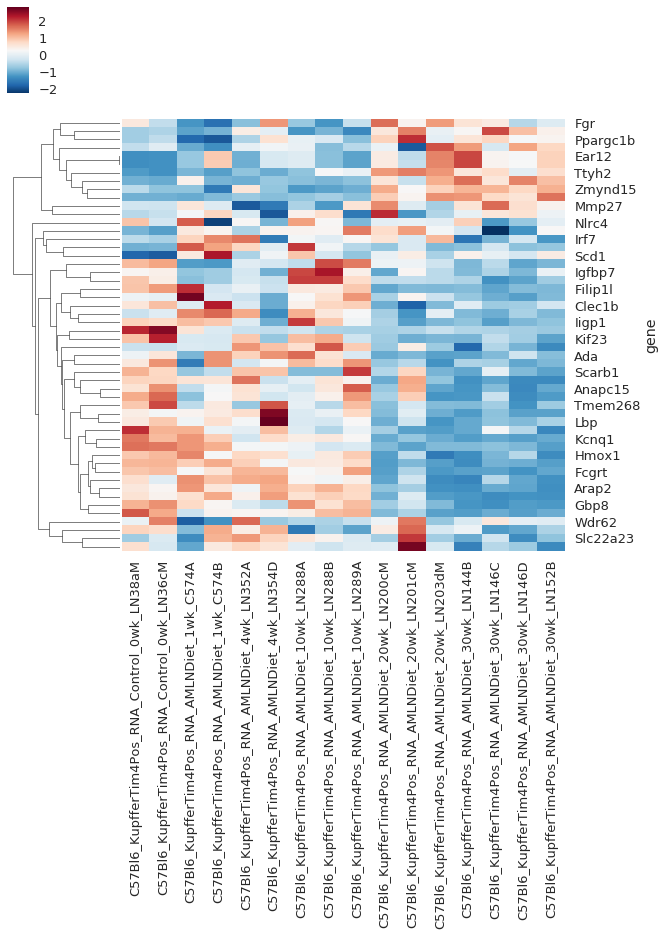

In [409]:
sns.clustermap(tpm_mat_filt.loc[kc_genes, :].loc[row_two_clust, :].dropna(),
                    z_score=0, cmap='RdBu_r', col_cluster=False)

In [399]:
de_sermut_genes = ['Nnmt', 'Hamp2', 'Thrsp',
                   'Ppp1r3g', 'Cyp2c69', 'Cyp2b13',
                   'Cyp2b9', 'Ces1f', 'Slc22a26',
                   'Bex1', 'Syngr1', 'Wfdc3',
                   'Fabp5', 'Timp1', 'Atp06vd2',
                   'Scara3', 'Obspl3', 'Cx3cr1',
                   'Col1a1', 'Spp1', 'Osbpl3',
                   'Acss3', 'Elovl3', 'Fads1',
                   'Fads2', 'Elovl5', 'Ascl1',
                   'Acox1', 'Acaa1b', 'Acad11',
                   'Acadm']

Plot genes from the mutated serine mice in the Becares et al 2017 BioRXiv paper.

Of the ones with a name that matches our gene name we see that genes that were downregulated by removing the phosphate group are upregulated in the later stages of NASH!

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


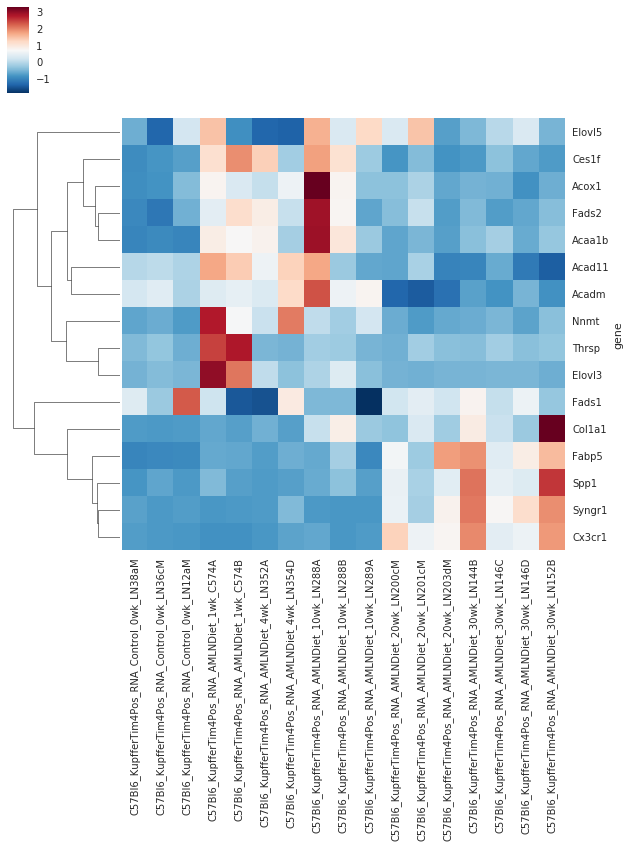

In [95]:
sns.clustermap(tpm_mat_filt.loc[de_sermut_genes, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False)

### Look at LXR and SREBP pathways

SREBP pathway

In [410]:
chol_met_proc = hbUtils.pull_go_terms("GO:0008203", taxon_id='10090', product_type='protein')
chol_met_proc = [entry[1] for entry in chol_met_proc]
chol_biosyn_proc = hbUtils.pull_go_terms("GO:0006695", taxon_id='10090', product_type='protein')
chol_biosyn_proc = [entry[1] for entry in chol_biosyn_proc]

srebp = list(set(chol_biosyn_proc + chol_met_proc))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


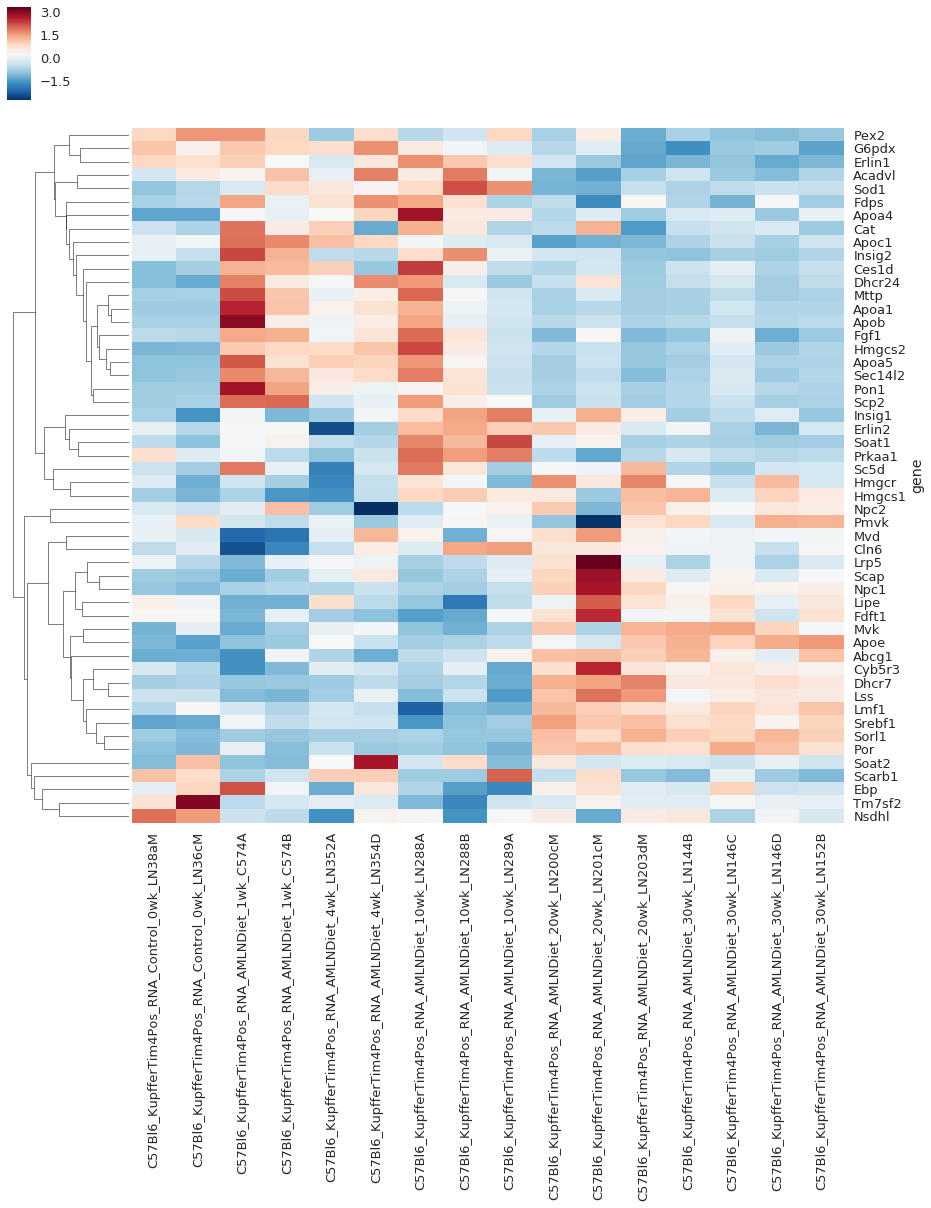

In [411]:
sns.clustermap(tpm_mat_filt.loc[srebp, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

LXR Pathway

In [412]:
with open('/home/h1bennet/data/gene_lists/mouse/LXRDKODown2foldGenes.txt') as f:
    lxrko_down = [i.strip() for i in f.readlines()]
    
with open('/home/h1bennet/data/gene_lists/mouse/LXRDKOUp2foldGenes.txt') as f:
    lxrko_up = [i.strip() for i in f.readlines()]

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


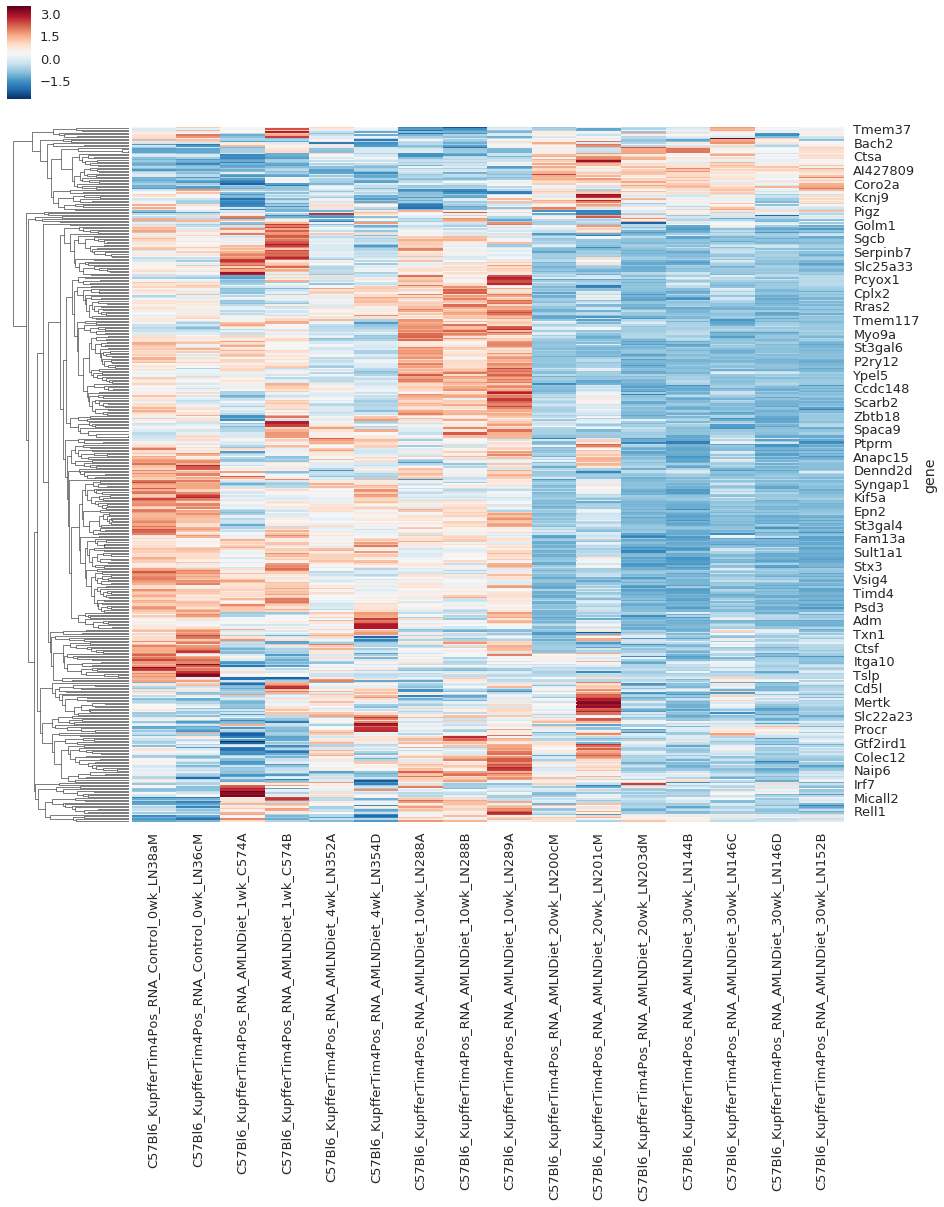

In [413]:
sns.clustermap(tpm_mat_filt.loc[lxrko_down, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


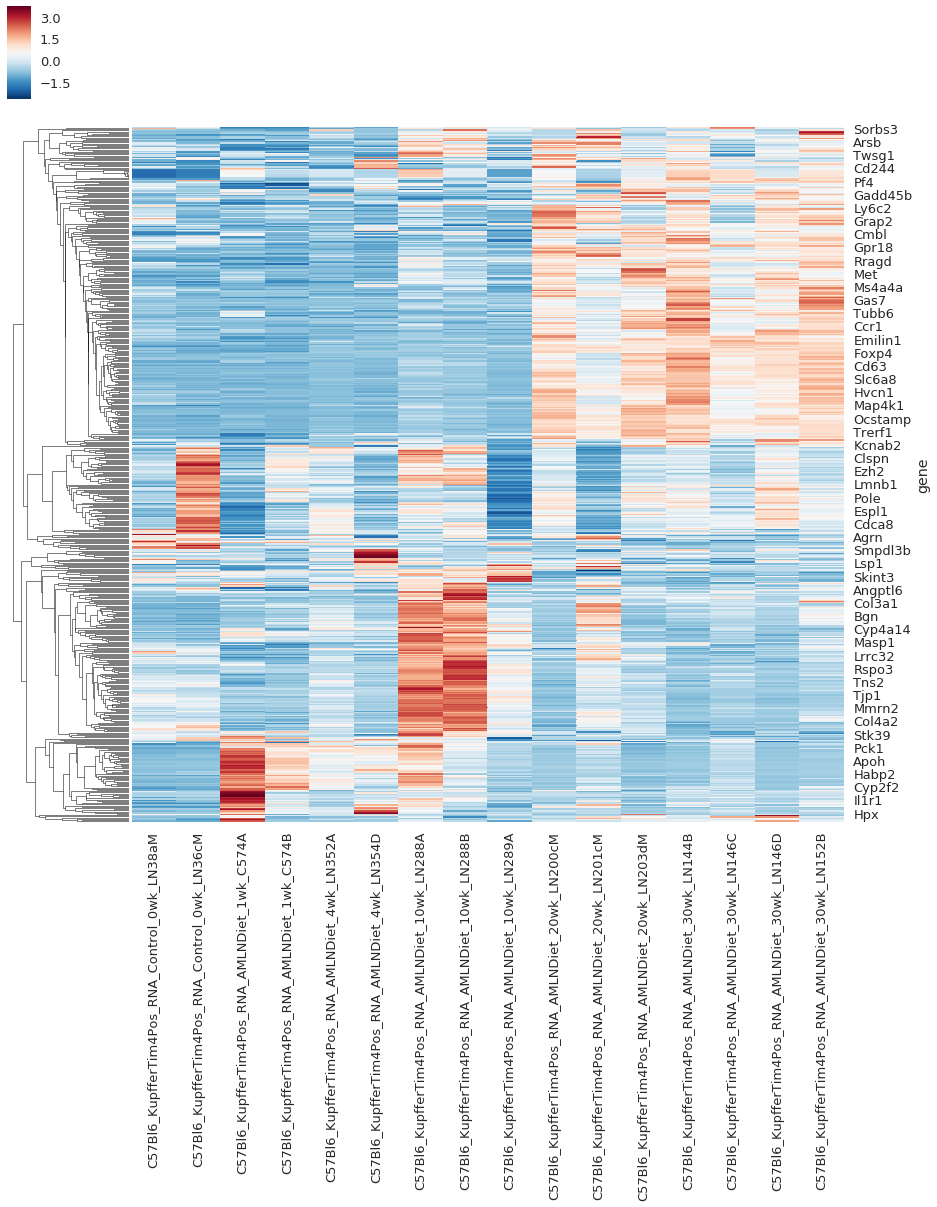

In [414]:
sns.clustermap(tpm_mat_filt.loc[lxrko_up, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

Compare to interesting LXR Pathway GO terms

In [415]:
pos_reg_lipid_trans = hbUtils.pull_go_terms("GO:0032370", taxon_id='10090', product_type='protein')
pos_reg_lipid_trans = [entry[1] for entry in pos_reg_lipid_trans]
pos_reg_chol_eff = hbUtils.pull_go_terms("GO:0010875", taxon_id='10090', product_type='protein')
pos_reg_chol_eff = [entry[1] for entry in pos_reg_chol_eff]
# lipid_biosyn_proc = hbUtils.pull_go_terms("GO:0008610", taxon_id='10090', product_type='protein')
# lipid_biosyn_proc = [entry[1] for entry in lipid_biosyn_proc]
trigly_met_proc = hbUtils.pull_go_terms("GO:0006641", taxon_id='10090', product_type='protein')
trigly_met_proc = [entry[1] for entry in trigly_met_proc]
lxr = list(set(pos_reg_lipid_trans + pos_reg_chol_eff + trigly_met_proc))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


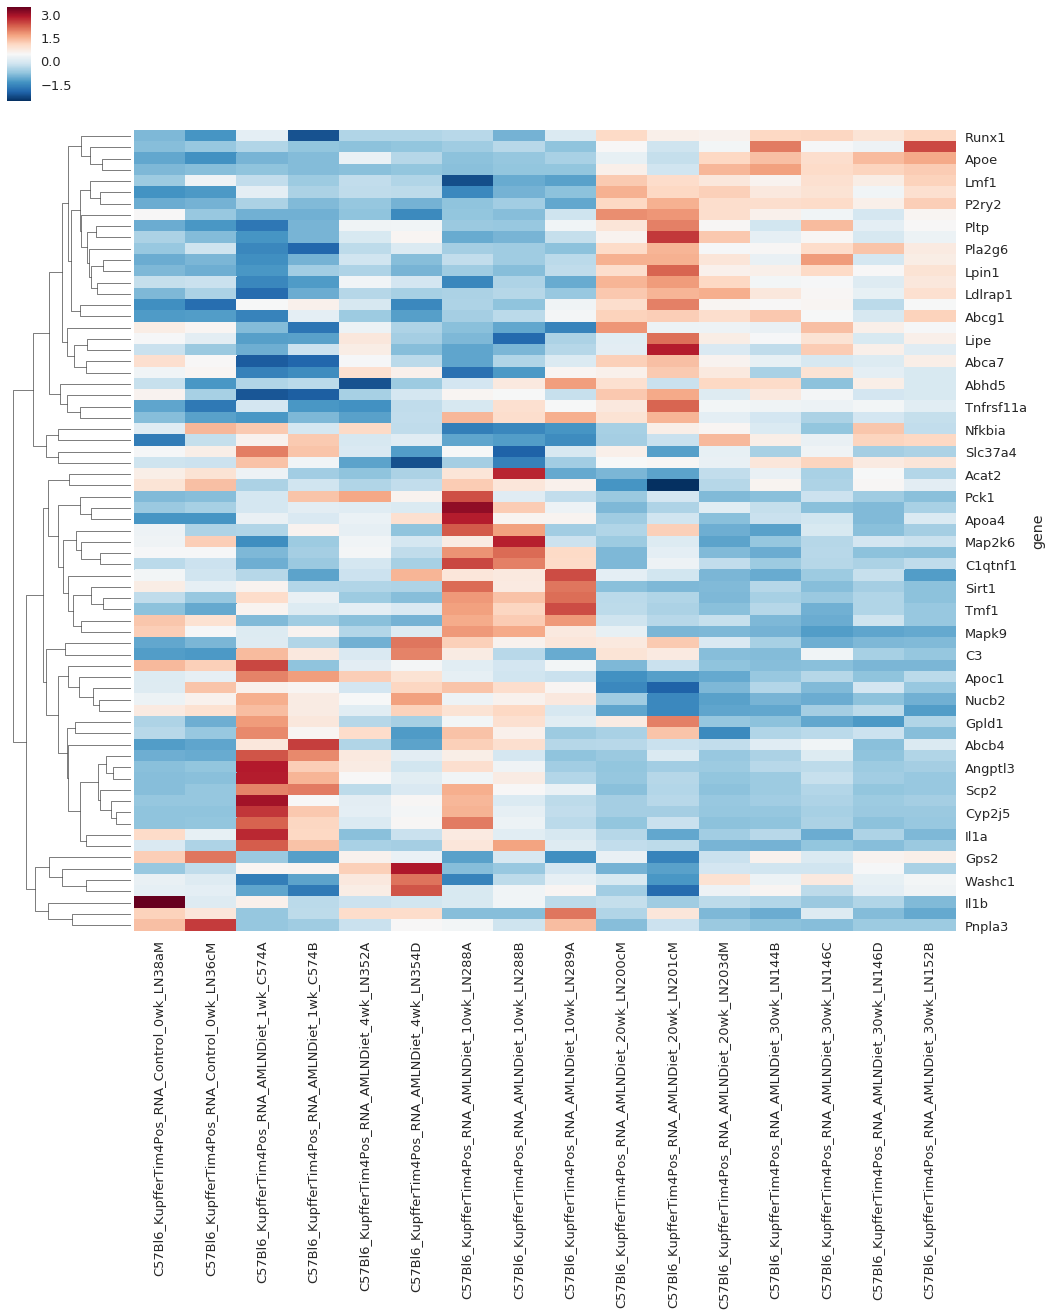

In [416]:
sns.clustermap(tpm_mat_filt.loc[lxr, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(17,17))